In [64]:
import os
import json
import re
# read file
# Get current working directory (notebook location)
base_dir = os.getcwd()

# Path to the "results" folder
results_dir = os.path.join(base_dir, 'result')

# Path to the figure output dir
figures_dir = os.path.join(base_dir, 'figure')
os.makedirs(figures_dir, exist_ok=True)

# Path to the latex table output dir
tables_dir = os.path.join(base_dir, 'table')
os.makedirs(tables_dir, exist_ok=True)


In [65]:
# match stage latency
stage_time = {} # stage_name: str -> list[latency: float]
# Regex pattern to match folders like "20250425_080607"
folder_pattern = re.compile(r'^\d{8}_\d{6}$')
latency_pattern = re.compile(r"(\w+)\s+time:\s+([\d.e-]+)")
for folder_name in os.listdir(results_dir):
    folder_path = os.path.join(results_dir, folder_name)

    if os.path.isdir(folder_path) and folder_pattern.match(folder_name):
        print(f"Reading folder: {folder_path}")

        # Iterate through all JSON files in the folder
        for file_name in os.listdir(folder_path):
            if file_name.endswith('api_server.log'):
                file_path = os.path.join(folder_path, file_name)
                try:
                    with open(file_path, 'r', encoding='utf-8') as file:
                        print(f"Loaded file: {file_path}")
                        for line in file:
                            match = latency_pattern.search(line)
                            if match:
                                stage_name, time = match.groups()
                                if stage_name not in stage_time:
                                    stage_time[stage_name] = []
                                stage_time[stage_name].append(float(time))
                except Exception as e:
                    print(f"Error reading file {file_path}: {e}")

Reading folder: G:\ustc\m大模型推理优化加速\paper\dxz\evaluation\slo_attainment\result\20250506_093741
Loaded file: G:\ustc\m大模型推理优化加速\paper\dxz\evaluation\slo_attainment\result\20250506_093741\ours-1e3p4d_api_server.log


In [66]:
print(stage_time.keys())
for key, value in stage_time.items():
    print(f'{key} len(value) {len(value)}')
    if len(value) < 10:
        del stage_time[key]

dict_keys(['encode_queueing', 'encode_execute', 'ep_transfer', 'prefill_queueing', 'prefill_execute', 'pd_transfer', 'decode_queueing', 'decode_execute'])
encode_queueing len(value) 6234
encode_execute len(value) 6234
ep_transfer len(value) 6234
prefill_queueing len(value) 6234
prefill_execute len(value) 6234
pd_transfer len(value) 6234
decode_queueing len(value) 6234
decode_execute len(value) 6233


In [68]:
from dataclasses import dataclass, field
import numpy as np
def split_list_by_ratio(lst):
    ratios = list(range(1, 13))  # [1, 2, ..., 12]
    total = sum(ratios)  # 78
    n = len(lst)

    lengths = [int(n * r / total) for r in ratios]

    while sum(lengths) < n:
        for i in range(len(lengths)):
            lengths[i] += 1
            if sum(lengths) == n:
                break

    result = []
    idx = 0
    for l in lengths:
        result.append(lst[idx:idx+l])
        idx += l
    return result

@dataclass
class BarData:
    encode_queueing: list[float] = field(default_factory=list)
    encode_execute: list[float] = field(default_factory=list)
    ep_transfer: list[float] = field(default_factory=list)
    prefill_queueing: list[float] = field(default_factory=list)
    prefill_execute: list[float] = field(default_factory=list)
    pd_transfer: list[float] = field(default_factory=list)
    decode_queueing: list[float] = field(default_factory=list)
    decode_execute: list[float] = field(default_factory=list)
    
bar_data = BarData()
for stage_name, value in stage_time.items():
    all_request_rate_latencies = split_list_by_ratio(value)
    for latencies in all_request_rate_latencies:
        avg_latencies = np.mean(latencies)
        getattr(bar_data, stage_name).append(avg_latencies)
        
@dataclass
class CDFData:
    ep_transfer: list[float]
    pd_transfer: list[float]
    
cdf_data = CDFData(ep_transfer=stage_time['ep_transfer'], pd_transfer=stage_time['pd_transfer'])

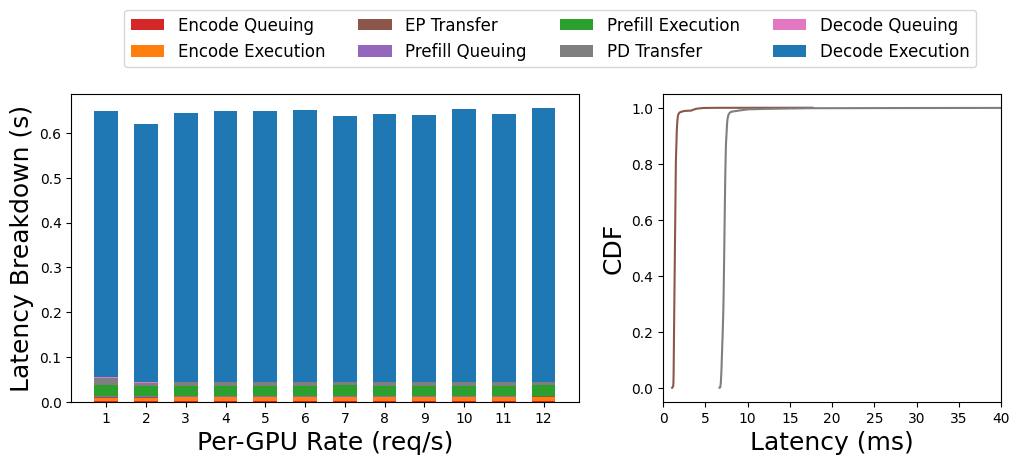

In [90]:
import matplotlib.pyplot as plt
import numpy as np

x_labels = [str(i) for i in range(1, 13)]
x = np.arange(len(x_labels))
width = 0.6

ep_transfer       = bar_data.ep_transfer       
prefill_queueing  = bar_data.prefill_queueing  
prefill_execute   = bar_data.prefill_execute   
pd_transfer       = bar_data.pd_transfer       
decode_queueing   = bar_data.decode_queueing   
decode_execute    = bar_data.decode_execute    
encode_queueing   = bar_data.encode_queueing   
encode_execute    = bar_data.encode_execute    

colors = plt.get_cmap('tab10').colors
stages = [
    (encode_queueing,  colors[3], 'Encode Queuing'),
    (encode_execute,   colors[1], 'Encode Execution'),
    (ep_transfer,      colors[5], 'EP Transfer'),
    (prefill_queueing, colors[4], 'Prefill Queuing'),
    (prefill_execute,  colors[2], 'Prefill Execution'), 
    (pd_transfer,      colors[7], 'PD Transfer'),       
    (decode_queueing,  colors[6], 'Decode Queuing'),    
    (decode_execute,   colors[0], 'Decode Execution'),  
]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [3, 2]})
plt.subplots_adjust(wspace=0.2)

bottom = np.zeros(len(x))
for values, color, label in stages:
    ax1.bar(x, values, width, bottom=bottom, color=color, label=label)
    bottom += np.array(values)

fontsize=18
ax1.set_xticks(x)
ax1.set_xticklabels(x_labels)
ax1.set_ylabel("Latency Breakdown (s)", fontsize=fontsize)
ax1.set_xlabel("Per-GPU Rate (req/s)", fontsize=fontsize)
ax1.legend(loc='upper right', bbox_to_anchor=(1.8, 1.3), ncol=4, fontsize=fontsize-6)

for values, label, color in [
    (cdf_data.ep_transfer, 'EP Transfer', colors[5]),
    (cdf_data.pd_transfer, 'PD Transfer', colors[7]),
]:
    sorted_vals = np.sort(values)
    cdf = np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
    ax2.plot(sorted_vals, cdf, linestyle='-', label=label, color=color)

ax2.set_xlim(0, 0.04)
ax2.set_xticks(ax2.get_xticks())
ax2.set_xticklabels([f'{tick*1000:.0f}' for tick in ax2.get_xticks()])
ax2.set_xlabel("Latency (ms)", fontsize=fontsize)
ax2.set_ylabel("CDF", fontsize=fontsize)
ax2.grid(False)

fig.savefig(os.path.join(figures_dir, f"latency_breakdown.pdf"), bbox_inches="tight")